In [1]:
import os
import urllib
from functools import reduce
from scipy import stats
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download data

In [3]:
os.makedirs("data", exist_ok=True)
for d in ["train", "test"]:
  json_path = f"data/{d}_products.json"
  url_data = f"https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Danone+Hackathon+Mexico/data/{d}_products.json"
  if not os.path.exists(json_path):
    urllib.request.urlretrieve(url_data, json_path)

# Read data

In [4]:
!ls data/

test_products.json  train_products.json


In [5]:
df = pd.read_json("data/train_products.json", orient="index")\
  .replace({"unknown": np.nan})
df["n_selling_countries"] = df["selling_countries"].str.len()
df["n_ingredients"] = df["ingredients"].str.len()

# top packaging materials
categories_packaging_materials = list(reduce(lambda x, y: set.union(x, y), df["packaging_materials"].apply(set).tolist()))
packaging_df = pd.DataFrame()
for material in categories_packaging_materials:
    packaging_df[f"{material}"] = df[f"packaging_materials"] .apply(lambda x: material in x if isinstance(x, list) else x)

top_materials = packaging_df.sum().sort_values(ascending=False).head(10).index.tolist()
for material in top_materials:
    df[f"packaging_materials_{material[3:]}"] = df[f"packaging_materials"].apply(lambda x: material in x if isinstance(x, list) else x)

# product categories
def get_categories_hierarchy(x):
    return " ".join([i[3:] for i in x if isinstance(x, list)])
df["categories_hierarchy_text"] = df["categories_hierarchy"].fillna("").apply(get_categories_hierarchy)

# Ingredients
def get_ingredients(x):
    return " ".join([i.get('id', "")[3:] for i in x if isinstance(x, list)])
df["ingredients_text"] = df["ingredients"].fillna("").apply(get_ingredients)

# selling_countries
df["selling_countries_text"] = df["selling_countries"].fillna("").apply(get_categories_hierarchy)
df.head()

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,packaging_materials_metal,packaging_materials_glass,packaging_materials_paper,packaging_materials_heavy-aluminium,packaging_materials_pp-polypropylene,packaging_materials_tetra-pak,packaging_materials_pet-polyethylene-terephthalate,categories_hierarchy_text,ingredients_text,selling_countries_text
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère",NaN,"[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",1.0,NaN,...,False,False,False,False,False,False,False,frozen-foods frozen-fried-potatoes frozen-cook...,potato rice-flour sunflower-oil potato-powder ...,france
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour",NaN,"[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...",10.0,NaN,...,False,False,False,False,False,False,False,snacks desserts sweet-snacks festive-foods bis...,glucose-syrup sugar wheat-flour fresh-egg butt...,france
2,Cini Minis,"Nestlé, Nestlé",,"[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...",3.0,0.635,...,False,False,False,False,False,False,False,plant-based-foods-and-beverages plant-based-fo...,whole-wheat-flour rice-flour sugar sunflower-o...,austria france germany spain switzerland
3,Cuor di fette Carrefour,Carrefour,NaN,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",2.0,NaN,...,False,False,False,False,False,False,False,dairies fermented-foods fermented-milk-product...,cheese concentrated-whey water butter milk-pro...,italy
4,Curry,"Carrefour,Groupe Carrefour",NaN,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....",0.0,NaN,...,False,True,False,False,False,False,False,plant-based-foods-and-beverages plant-based-fo...,turmeric cumin coriander fenugreek parsley hot...,france


In [6]:
x_test = pd.read_json("data/test_products.json", orient="index")\
  .replace({"unknown": np.nan})
x_test["n_selling_countries"] = x_test["selling_countries"].str.len()
x_test["n_ingredients"] = x_test["ingredients"].str.len()

# top packaging materials
for material in top_materials:
    x_test[f"packaging_materials_{material[3:]}"] = x_test[f"packaging_materials"] .apply(lambda x: material in x if isinstance(x, list) else x)

# product categories
x_test["categories_hierarchy_text"] = x_test["categories_hierarchy"].fillna("").apply(get_categories_hierarchy)

# Ingredients
x_test["ingredients_text"] = x_test["ingredients"].fillna("").apply(get_ingredients)

# selling_countries
x_test["selling_countries_text"] = x_test["selling_countries"].fillna("").apply(get_categories_hierarchy)

x_test.head()

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,packaging_materials_metal,packaging_materials_glass,packaging_materials_paper,packaging_materials_heavy-aluminium,packaging_materials_pp-polypropylene,packaging_materials_tetra-pak,packaging_materials_pet-polyethylene-terephthalate,categories_hierarchy_text,ingredients_text,selling_countries_text
0,Activia saveur coco x 4,"Danone,Activia",NaN,"[en:dairies, en:fermented-foods, en:desserts, ...",0,"[en:belgium, en:france]","{'en:european-union': 50, 'en:france': 50}","[{'id': 'en:whole-milk', 'percent_estimate': '...",0.0,NaN,...,False,False,False,False,False,False,False,dairies fermented-foods desserts fermented-mil...,whole-milk sugar condensed-skimmed-milk cream ...,belgium france
1,Danup peche melba,Danone,NaN,"[en:plant-based-foods-and-beverages, en:bevera...",1,[en:tunisia],{'en:unknown': 100},NaN,NaN,NaN,...,False,False,False,False,False,False,False,plant-based-foods-and-beverages beverages plan...,,tunisia
2,Off-the-charts cherry pie flavor not-so-tradit...,"Oikos,Danone",,"[en:dairies, en:fermented-foods, en:desserts, ...",0,"[en:france, en:united-states]",{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:yogu...",1.0,0.067,...,False,False,False,False,False,False,False,dairies fermented-foods desserts fermented-mil...,yogurt water cane-sugar cherry contains-less-t...,france united-states
3,Yaourt brassé nature,Danone,,"[en:dairies, en:fermented-foods, en:desserts, ...",0,[en:france],{'en:france': 100},"[{'id': 'en:whole-milk', 'origins': 'en:france...",0.0,0.149,...,False,False,False,False,False,False,False,dairies fermented-foods desserts fermented-mil...,whole-milk condensed-skimmed-milk cream lactic...,france
4,Activia yaourt à boire myrtille,"Danone,Activia",NaN,"[en:beverages, en:dairies, en:fermented-foods,...",1,[en:poland],{'en:unknown': 100},"[{'id': 'en:skimmed-milk', 'percent_estimate':...",0.0,0.105,...,False,False,False,True,False,False,False,beverages dairies fermented-foods desserts fer...,skimmed-milk sugar cream berries citrus-fibre ...,poland


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20835 entries, 0 to 20834
Data columns (total 43 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   name                                                  20507 non-null  object 
 1   brand                                                 20835 non-null  object 
 2   generic_name                                          2211 non-null   object 
 3   categories_hierarchy                                  20835 non-null  object 
 4   is_beverage                                           20835 non-null  int64  
 5   selling_countries                                     20832 non-null  object 
 6   ingredient_origins                                    20835 non-null  object 
 7   ingredients                                           15681 non-null  object 
 8   additives_count                                       15

In [8]:
df.columns

Index(['name', 'brand', 'generic_name', 'categories_hierarchy', 'is_beverage',
       'selling_countries', 'ingredient_origins', 'ingredients',
       'additives_count', 'calcium_100g', 'carbohydrates_100g',
       'energy_kcal_100g', 'fat_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'sugars_100g', 'nutrition_grade',
       'packaging_materials',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'ecoscore_grade', 'n_selling_countries', 'n_ingredients',
       'packaging_materials_unknown', 'packaging_materials_plastic',
       'packaging_materials_cardboard', 'packaging_materials_metal',
       'packaging_materials_glass', 'packaging_materials_paper',
       'packaging_materials_heavy-aluminium',
       'packaging_materials_pp-polypropylene', 'packaging_materials_tetra-pak',
       'packa

In [9]:
df.head(2)

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,packaging_materials_metal,packaging_materials_glass,packaging_materials_paper,packaging_materials_heavy-aluminium,packaging_materials_pp-polypropylene,packaging_materials_tetra-pak,packaging_materials_pet-polyethylene-terephthalate,categories_hierarchy_text,ingredients_text,selling_countries_text
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère",NaN,"[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",1.0,NaN,...,False,False,False,False,False,False,False,frozen-foods frozen-fried-potatoes frozen-cook...,potato rice-flour sunflower-oil potato-powder ...,france
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour",NaN,"[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...",10.0,NaN,...,False,False,False,False,False,False,False,snacks desserts sweet-snacks festive-foods bis...,glucose-syrup sugar wheat-flour fresh-egg butt...,france


Preprocesing

In [36]:
numerical_features = [
    "n_selling_countries", "n_ingredients", "additives_count", 'carbohydrates_100g','energy_kcal_100g',
    'fat_100g', 'fiber_100g', 'proteins_100g','salt_100g', 'sodium_100g', 'sugars_100g',
    "non_recyclable_and_non_biodegradable_materials_count",
    'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
    'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation'
  ]
categorical_features = ["is_beverage", "nutrition_grade",'packaging_materials_unknown',
 'packaging_materials_plastic', 'packaging_materials_cardboard', 'packaging_materials_metal',
 'packaging_materials_glass', 'packaging_materials_paper', 'packaging_materials_heavy-aluminium',
 'packaging_materials_pp-polypropylene', 'packaging_materials_tetra-pak','packaging_materials_pet-polyethylene-terephthalate'
 ]

text_features = ["ingredients_text", "categories_hierarchy_text", "selling_countries_text", 'brand']

preproc_numerical_baseline = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary"))

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, numerical_features),
    (preproc_categorical_baseline, categorical_features),
    remainder="drop")

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['n_selling_countries', 'n_ingredients',
                                  'additives_count', 'carbohydrates_100g',
                                  'energy_kcal_100g', 'fat_100g', 'fiber_100g',
                                  'proteins_100g', 'salt_100g', 'sodium_100g',
                                  'sugars_100g',
                                  'non_recyclable_and_non_biodegradable_materials_c...
                                 ['is_beverage', 'nutrition_grade',
                                  'packaging_materials_unknown',
                                  'packaging_materials_plastic',
                                  'packaging_materials_cardboard',
                                  'packaging_materials_metal',
                                  'packaging_materials_glass',
                                  'packaging_materials_paper',
                                  'packaging_materials_heavy-aluminium',
                                  'packaging_materials_pp-polypropylene',
                                  'packaging_materials_tetra-pak',
                                  'packaging_materials_pet-polyethylene-terephthalate'])])

In [37]:
X = df[numerical_features + categorical_features + text_features]
y = df["ecoscore_grade"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
print(f"{X_train.shape=}, {X_val.shape=}")

X_train.shape=(17709, 34), X_val.shape=(3126, 34)


# Training model

In [12]:
# Cache the preprocessing step of the pipeline
from tempfile import mkdtemp
from shutil import rmtree
cachedir = mkdtemp()

## Voting

In [13]:
gboost = GradientBoostingClassifier(n_estimators=100)
logit = LogisticRegression()
svm = SVC(C=1)
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=None))


model = VotingClassifier(
    estimators = [("gboost", gboost),
                  ("adaboost", adaboost),
                   ("logit", logit),
                   ("svm_rbf", svm)
                   ],
    weights = [1,1,1,1],
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc_baseline, model, memory=cachedir)

In [14]:
pipe_ensemble.fit(X_train, y_train)

Pipeline(memory='/tmp/tmpr_ppaalq',
         steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['n_selling_countries',
                                                   'n_ingredients',
                                                   'additives_count',
                                                   'carbohydrates_100g',
                                                   'energy_kcal_100g',
                                                   'fat_100g', 'fiber_100g',
                                                   'proteins_100g', 'salt_100g',
                                                   'sodium_100g',...
                                                   'packaging_materials_pp-polypropylene',
                                                   'packaging_materials_tetra-pak',
                                                   'packaging_materials_pet-polyethylene-terephthalate'])])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('gboost',
                                               GradientBoostingClassifier()),
                                              ('adaboost',
                                               AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
                                              ('logit', LogisticRegression()),
                                              ('svm_rbf', SVC(C=1))],
                                  n_jobs=-1, weights=[1, 1, 1, 1]))])

In [15]:
# score = cross_val_score(pipe_ensemble, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
# print(f"{score.mean()=}, {score.std()=}, {score=}")

In [16]:
# y_pred = pipe_ensemble.predict(X_val)
# classes = pipe_ensemble["votingclassifier"].classes_
# cm = confusion_matrix(y_val, y_pred, labels=classes)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=classes)
# disp.plot()

In [17]:
# predictions_test_votingclf = pd.Series(pipe_ensemble.predict(x_test), name="target").to_frame()
# predictions_test_votingclf.to_json("predictions_test_votingclf.json", orient="columns")

## CatBoost

In [38]:
from catboost import Pool, CatBoostClassifier

all_features = numerical_features +  categorical_features + text_features
cat_indexes = [all_features.index(a) for a in categorical_features]
text_indexes= [all_features.index(a) for a in text_features]


preproc_categorical_catboost = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
)

preproc_baseline_catboost = make_column_transformer(
    (preproc_numerical_baseline, numerical_features),
    (preproc_categorical_catboost, categorical_features),
    remainder="passthrough")

catboost_model = CatBoostClassifier(learning_rate=0.1,
        depth=5,
        cat_features=cat_indexes,
        text_features=text_indexes,
        iterations=800,
        task_type="GPU",
        early_stopping_rounds=10
)
catboost_pipeline = make_pipeline(preproc_baseline_catboost, catboost_model)


In [19]:
# grid = {
#       'catboostclassifier__learning_rate': stats.uniform(0.05, 0.3),
#       'catboostclassifier__depth': stats.randint(50,300),
#       'catboostclassifier__l2_leaf_reg': stats.uniform(0.05, 0.3)
# }

# search_gb = RandomizedSearchCV(catboost_pipeline, grid, scoring='f1_macro', n_iter=10, cv=3, n_jobs=-1, verbose=1,)

# Fit data to Grid Search
# search_gb.fit(X_train, y_train)
# print(search_gb.best_params_)
# search_gb.best_score_


In [20]:
# best_estimator = catboost_pipeline
# y_pred_catboost = best_estimator.predict(X_val)
# classes = best_estimator.classes_
# cm = confusion_matrix(y_val, y_pred_catboost, labels=classes)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=classes)
# disp.plot()
# best_estimator.score(X_val, y_val)

In [21]:
# predictions_test_catboost = pd.Series(best_estimator.predict(x_test).squeeze(), name="target").to_frame()
# predictions_test_catboost.to_json("predictions_test_catboost_text.json", orient="columns")

## Catboost complete

In [39]:
X_train_preproc = preproc_baseline_catboost.fit_transform(X_train, y_train)
X_eval_preproc = preproc_baseline_catboost.transform(X_val)
best_lr = 0.22333246374919907
catboost_model_complete = CatBoostClassifier(learning_rate=best_lr,
        depth=9,
        cat_features=cat_indexes,
        text_features=text_indexes,
        task_type="GPU",
        l2_leaf_reg=0.5,
        iterations=300
)

catboost_model_complete.fit(X_train_preproc, y_train,
        eval_set=(X_eval_preproc, y_val),
        early_stopping_rounds=10,
        )

0:	learn: 1.1464824	test: 1.1267418	best: 1.1267418 (0)	total: 173ms	remaining: 51.9s
1:	learn: 0.9439251	test: 0.9253416	best: 0.9253416 (1)	total: 300ms	remaining: 44.7s
2:	learn: 0.8130988	test: 0.7930636	best: 0.7930636 (2)	total: 383ms	remaining: 37.9s
3:	learn: 0.7171239	test: 0.6973468	best: 0.6973468 (3)	total: 450ms	remaining: 33.3s
4:	learn: 0.6499534	test: 0.6297304	best: 0.6297304 (4)	total: 517ms	remaining: 30.5s
5:	learn: 0.5986549	test: 0.5790844	best: 0.5790844 (5)	total: 575ms	remaining: 28.2s
6:	learn: 0.5565912	test: 0.5388344	best: 0.5388344 (6)	total: 638ms	remaining: 26.7s
7:	learn: 0.5189523	test: 0.5053639	best: 0.5053639 (7)	total: 708ms	remaining: 25.8s
8:	learn: 0.4887725	test: 0.4781643	best: 0.4781643 (8)	total: 756ms	remaining: 24.5s
9:	learn: 0.4658200	test: 0.4573192	best: 0.4573192 (9)	total: 822ms	remaining: 23.8s
10:	learn: 0.4451113	test: 0.4394650	best: 0.4394650 (10)	total: 898ms	remaining: 23.6s
11:	learn: 0.4329746	test: 0.4283463	best: 0.4283463

0.8774812844327837

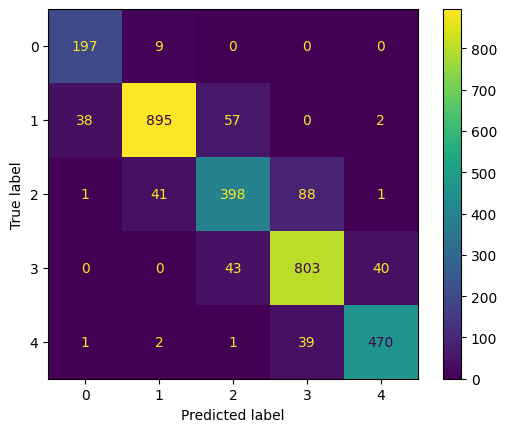

In [40]:
y_pred_catboost2 = catboost_model_complete.predict(X_eval_preproc)
classes = catboost_model_complete.classes_
cm = confusion_matrix(y_val, y_pred_catboost2, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()

f1_score(y_val, y_pred_catboost2, average="macro")

In [41]:
X_test_preproc = preproc_baseline_catboost.transform(x_test)
predictions_test_catboost_complete = pd.Series(catboost_model_complete.predict(X_test_preproc).squeeze(), name="target").to_frame()
predictions_test_catboost_complete.to_json("predictions_test_catboost_complete.json", orient="columns")